In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace 'path_to_file.csv' with the actual path to your dataset
file_path = 'C:/Users/Win11/Downloads/case-study-task-recipes.parquet'

# Loot at the data in all ways

In [21]:
# Load the Parquet file into a DataFrame
try:
    data = pd.read_parquet(file_path)
    df = pd.read_parquet(file_path)
    print("Dataset successfully loaded!")
except Exception as e:
    print(f"Failed to load the dataset: {e}")
    exit()


Dataset successfully loaded!


In [17]:
# Display basic information about the dataset
print("\n--- Dataset Overview ---")
print(data.info())

# Check for missing values
print("\n--- Missing Values ---")
print(data.isnull().sum())

# Display the first few rows of the dataset
print("\n--- First 5 Rows ---")
data.head()


--- Dataset Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64400 entries, 0 to 64399
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             64400 non-null  datetime64[ms]
 1   recipe_id        64400 non-null  object        
 2   no_hits          64400 non-null  int64         
 3   no_sessions      64400 non-null  int64         
 4   name             64400 non-null  object        
 5   description      64400 non-null  object        
 6   preparationtime  64400 non-null  int64         
 7   difficulty       64400 non-null  object        
 8   steps            64400 non-null  int64         
 9   instructions     64400 non-null  object        
 10  tags             64400 non-null  object        
dtypes: datetime64[ms](1), int64(4), object(6)
memory usage: 5.4+ MB
None

--- Missing Values ---
date               0
recipe_id          0
no_hits            0
no_sessions    

,date,recipe_id,no_hits,no_sessions,name,description,preparationtime,difficulty,steps,instructions,tags
0,2023-01-08,1052,15,13,Mashed Avocado & Peas with Cauliflower,Our creamy Mashed Avocado & Peas with Cauliflo...,35,easy,8,"[Preheat the oven to 360°F (180°C)., Start by ...","low_carb,dinner,lunch,vegan,vegetarian,gluten_..."
1,2023-01-25,1052,12,10,Mashed Avocado & Peas with Cauliflower,Our creamy Mashed Avocado & Peas with Cauliflo...,35,easy,8,"[Preheat the oven to 360°F (180°C)., Start by ...","low_carb,dinner,lunch,vegan,vegetarian,gluten_..."
2,2023-01-26,1052,13,11,Mashed Avocado & Peas with Cauliflower,Our creamy Mashed Avocado & Peas with Cauliflo...,35,easy,8,"[Preheat the oven to 360°F (180°C)., Start by ...","low_carb,dinner,lunch,vegan,vegetarian,gluten_..."
3,2023-01-19,1052,11,9,Mashed Avocado & Peas with Cauliflower,Our creamy Mashed Avocado & Peas with Cauliflo...,35,easy,8,"[Preheat the oven to 360°F (180°C)., Start by ...","low_carb,dinner,lunch,vegan,vegetarian,gluten_..."
4,2023-01-09,1052,14,14,Mashed Avocado & Peas with Cauliflower,Our creamy Mashed Avocado & Peas with Cauliflo...,35,easy,8,"[Preheat the oven to 360°F (180°C)., Start by ...","low_carb,dinner,lunch,vegan,vegetarian,gluten_..."


Some assum(P)tions regarding the data
- When we look at a country, we look at the cam(P)aings on which the country is a target country
- We can indistinctevely using sessions or visits 

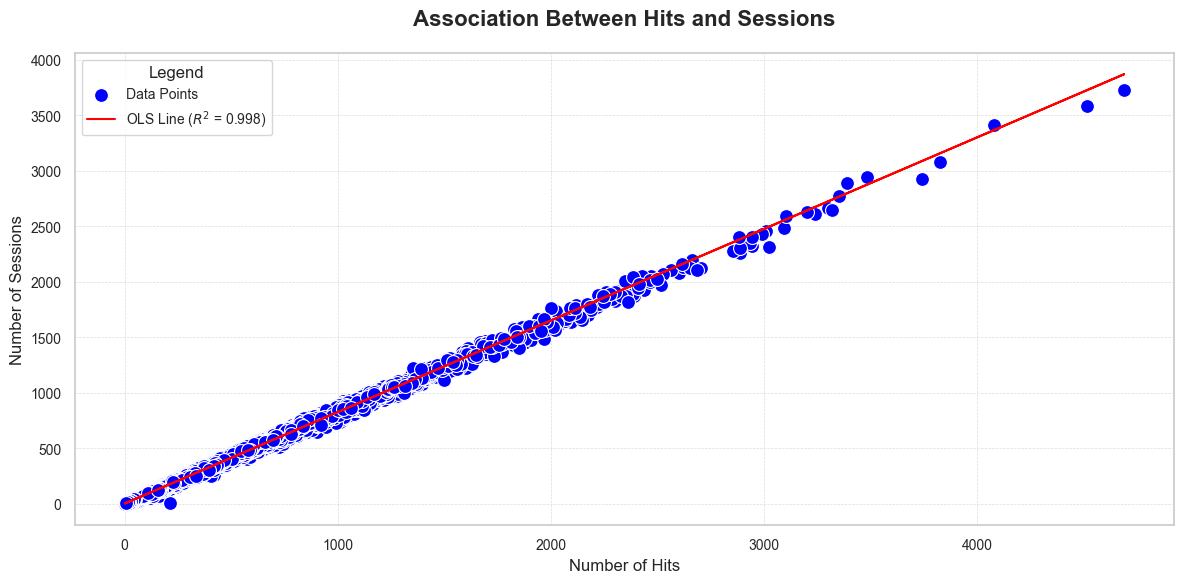

In [159]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Step 1: Fit an OLS Regression
X = df[['no_hits']]  # Predictor
y = df['no_sessions']  # Response
model = LinearRegression()
model.fit(X, y)
df['predicted_sessions'] = model.predict(X)  # Add predictions to DataFrame
r2 = r2_score(y, df['predicted_sessions'])  # Calculate R^2

### Step 2: Create the McKinsey-Style Scatterplot
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
# Scatterplot
sns.scatterplot(x='no_hits', y='no_sessions', data=df, color='blue', s=100, label='Data Points')
# OLS Line
plt.plot(df['no_hits'], df['predicted_sessions'], color='red', label=f'OLS Line ($R^2$ = {r2:.3f})')

# Styling
plt.title("Association Between Hits and Sessions", fontsize=16, weight="bold", pad=20)
plt.xlabel("Number of Hits", fontsize=12)
plt.ylabel("Number of Sessions", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10, title="Legend", title_fontsize=12)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


I don't care what to use. Visits seems more clear

In [57]:
# Step 1: Aggregate by Recipe ID
aggregated = data.groupby('recipe_id').agg(
    total_hits=('no_hits', 'sum'),
    total_sessions=('no_sessions', 'sum'),
    avg_hits_per_day=('no_hits', 'mean'),
    avg_sessions_per_day=('no_sessions', 'mean'),
    preparation_time=('preparationtime', 'mean'),
    difficulty=('difficulty', 'first'),
    tags=('tags', 'first')
).reset_index()

# Step 2: Define Benchmarks
hits_threshold = aggregated['total_hits'].quantile(0.8)  # Top 20%
sessions_threshold = aggregated['total_sessions'].quantile(0.8)

# Step 3: Classify Recipes
aggregated['success'] = (aggregated['total_hits'] >= hits_threshold) & (aggregated['total_sessions'] >= sessions_threshold)

# Step 4: Output Results
print("Aggregated Data with Classification:")

Aggregated Data with Classification:


In [50]:
# Split the tags column into individual tags
unique_tags = set()
df['tags'].str.split(',').apply(unique_tags.update)  # Update the set with tags from each row
unique_tags = sorted(unique_tags)  # Sort for consistent column order

print("Unique Tags Found:", unique_tags)

### Step 2: Create Binary Variables
for tag in unique_tags:
    df[f'tag_{tag}'] = df['tags'].apply(lambda x: 1 if tag in x.split(',') else 0)

### Step 3: Drop Original Tags Column (Optional)
# If the original tags column is no longer needed
df = df.drop(columns=['tags'])


Unique Tags Found: ['100kcal', '200kcal', '300kcal', '400kcal', '500kcal', '50kcal', '600kcal', '700kcal', 'baking', 'basic', 'breakfast', 'casserole', 'christmas', 'clean_eating', 'dessert', 'detox', 'dinner', 'easy', 'fast', 'few_ingredients', 'fish', 'fruits', 'gluten_free', 'high_fiber', 'high_protein', 'ketogenic', 'lactose_free', 'low_calorie', 'low_carb', 'low_fat', 'lunch', 'meat', 'on_the_go', 'pescatarian', 'salad', 'shake', 'smoothie', 'snack', 'soup', 'sugar_free', 'sweet', 'vegan', 'vegetables', 'vegetarian']


In [ ]:
df['description'].unique()
df['tags'].unique()
df['name'].nunique()

2119

Now you have all the information and you can continue

In [ ]:
# Cross-correlation and segmentation
binary_tag_columns = [col for col in aggregated.columns if col.startswith('tag_')]
correlation_matrix = aggregated[binary_tag_columns].corr()

# Understand the timings

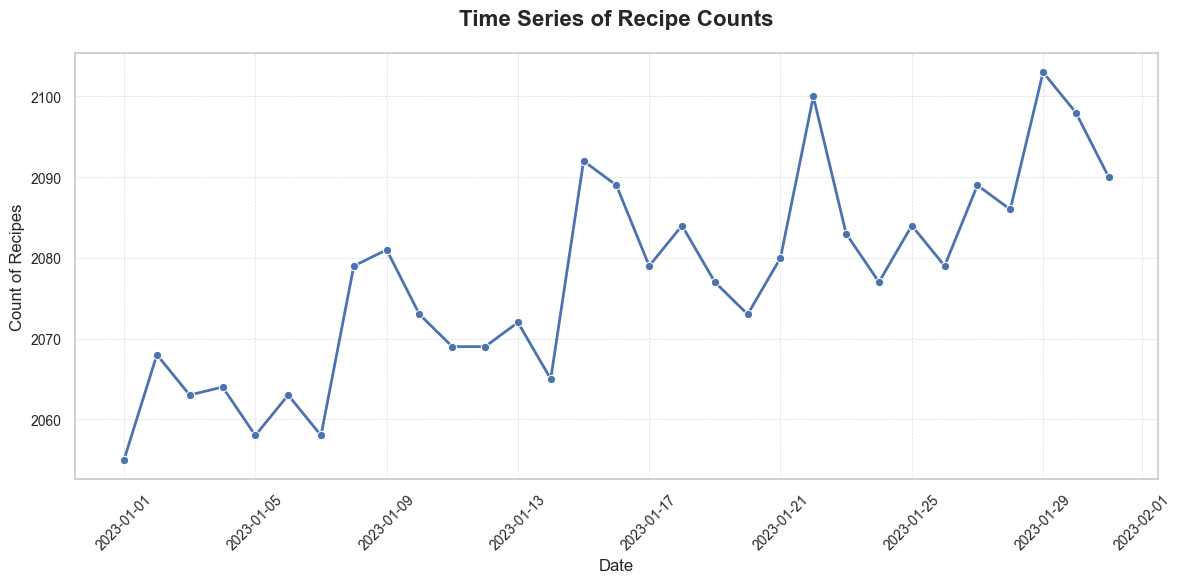

In [27]:
# Group by date and count the number of rows (recipes) for each date
daily_counts = df.groupby('date').size().reset_index(name='recipe_count')

### Step 2: Plot Configuration
sns.set_theme(style="whitegrid")  # McKinsey-style grid background

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='recipe_count', data=daily_counts, marker='o', linewidth=2, color='b')

# Styling the plot
plt.title("Time Series of Recipe Counts", fontsize=16, weight='bold', pad=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Count of Recipes", fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a margin for better readability
plt.tight_layout()

# Show the plot
plt.show()

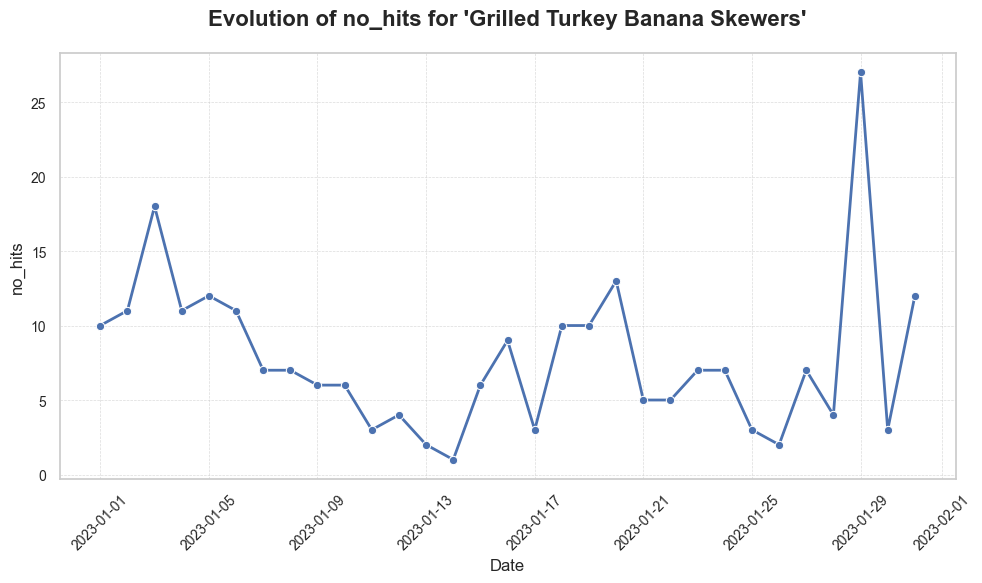

In [35]:
import random

### Step 1: Randomly Select a Recipe
selected_recipe_id = random.choice(df['recipe_id'].unique())
selected_recipe_name = df[df['recipe_id'] == selected_recipe_id]['name'].iloc[0]

# Filter data for the selected recipe
recipe_data = df[df['recipe_id'] == selected_recipe_id]

### Step 2: Prepare Plot
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='no_hits', data=recipe_data, marker='o', linewidth=2, color='b')

# Styling the plot
plt.title(f"Evolution of no_hits for '{selected_recipe_name}'", fontsize=16, weight='bold', pad=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("no_hits", fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a margin for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [36]:
# Group by date and recipe_id, summing up the hits
aggregated_data = df.groupby(['date', 'recipe_id']).agg({'no_hits': 'sum'}).reset_index()

# Pivot data for visualization
time_series = aggregated_data.pivot(index='date', columns='recipe_id', values='no_hits')

# Plot Configuration
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 8))
for recipe_id in time_series.columns:
    sns.lineplot(x=time_series.index, y=time_series[recipe_id], label=f"Recipe {recipe_id}")

# Styling the plot
plt.title("Evolution of no_hits for All Recipes", fontsize=16, weight='bold', pad=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("no_hits", fontsize=12)

# Display only the first and last dates on the x-axis
plt.xticks([time_series.index[0], time_series.index[-1]],
           [time_series.index[0].strftime('%Y-%m-%d'), time_series.index[-1].strftime('%Y-%m-%d')],
           fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Recipe ID", fontsize=10, title_fontsize=12)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Tight layout and display
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000225FA0FA5C0> (for post_execute):


KeyboardInterrupt: 

In [37]:
# Step 1: Count unique dates per recipe
unique_dates_per_recipe = df.groupby('recipe_id')['date'].nunique().reset_index()
unique_dates_per_recipe.columns = ['recipe_id', 'unique_date_count']

# Step 2: Filter recipes with fewer than 28 unique dates
recipes_less_than_28 = unique_dates_per_recipe[unique_dates_per_recipe['unique_date_count'] < 28]
recipes_less_than_28

# Overall all rec are okay and the data is richfull. 


,recipe_id,unique_date_count
29,1024,21
30,1025,23
132,1117,20
159,1141,18
178,1159,27
...,...,...
1590,521,27
1627,555,26
1701,621,21
1817,726,23


In [39]:
recipes_less_than_10 = unique_dates_per_recipe[unique_dates_per_recipe['unique_date_count'] < 10]
recipes_less_than_10

,recipe_id,unique_date_count
1241,2151,3
1242,2152,3
1243,2153,3
1244,2154,3
1245,2155,3
1246,2156,3
1247,2157,3
1248,2158,3
1249,2159,3
1251,2160,3


In [45]:
df[df['recipe_id'] == '2151']
df

,date,recipe_id,no_hits,no_sessions,name,description,preparationtime,difficulty,steps,instructions,tags
0,2023-01-08,1052,15,13,Mashed Avocado & Peas with Cauliflower,Our creamy Mashed Avocado & Peas with Cauliflo...,35,easy,8,"[Preheat the oven to 360°F (180°C)., Start by ...","low_carb,dinner,lunch,vegan,vegetarian,gluten_..."
1,2023-01-25,1052,12,10,Mashed Avocado & Peas with Cauliflower,Our creamy Mashed Avocado & Peas with Cauliflo...,35,easy,8,"[Preheat the oven to 360°F (180°C)., Start by ...","low_carb,dinner,lunch,vegan,vegetarian,gluten_..."
2,2023-01-26,1052,13,11,Mashed Avocado & Peas with Cauliflower,Our creamy Mashed Avocado & Peas with Cauliflo...,35,easy,8,"[Preheat the oven to 360°F (180°C)., Start by ...","low_carb,dinner,lunch,vegan,vegetarian,gluten_..."
3,2023-01-19,1052,11,9,Mashed Avocado & Peas with Cauliflower,Our creamy Mashed Avocado & Peas with Cauliflo...,35,easy,8,"[Preheat the oven to 360°F (180°C)., Start by ...","low_carb,dinner,lunch,vegan,vegetarian,gluten_..."
4,2023-01-09,1052,14,14,Mashed Avocado & Peas with Cauliflower,Our creamy Mashed Avocado & Peas with Cauliflo...,35,easy,8,"[Preheat the oven to 360°F (180°C)., Start by ...","low_carb,dinner,lunch,vegan,vegetarian,gluten_..."
...,...,...,...,...,...,...,...,...,...,...,...
64395,2023-01-17,1537,10,10,Lemon Hummus with Hemp Seeds,Our Lemon Hummus with Hemp Seeds is packed wit...,15,easy,5,[Peel and finely chop the garlic. Zest the pee...,"snack,high_fiber,vegan,vegetarian,lactose_free..."
64396,2023-01-14,1537,21,12,Lemon Hummus with Hemp Seeds,Our Lemon Hummus with Hemp Seeds is packed wit...,15,easy,5,[Peel and finely chop the garlic. Zest the pee...,"snack,high_fiber,vegan,vegetarian,lactose_free..."
64397,2023-01-13,1537,17,14,Lemon Hummus with Hemp Seeds,Our Lemon Hummus with Hemp Seeds is packed wit...,15,easy,5,[Peel and finely chop the garlic. Zest the pee...,"snack,high_fiber,vegan,vegetarian,lactose_free..."
64398,2023-01-12,1537,16,14,Lemon Hummus with Hemp Seeds,Our Lemon Hummus with Hemp Seeds is packed wit...,15,easy,5,[Peel and finely chop the garlic. Zest the pee...,"snack,high_fiber,vegan,vegetarian,lactose_free..."


In [47]:
# I also want to check the count of distinct 
### Step 1: Count Unique Values per Recipe
# Group by recipe_id and count unique values for each column
unique_counts = df.groupby('recipe_id').agg({
    'name': 'nunique',
    'description': 'nunique',
    'preparationtime': 'nunique',
    'difficulty': 'nunique',
    'steps': 'nunique',
    'tags': 'nunique'
}).reset_index()



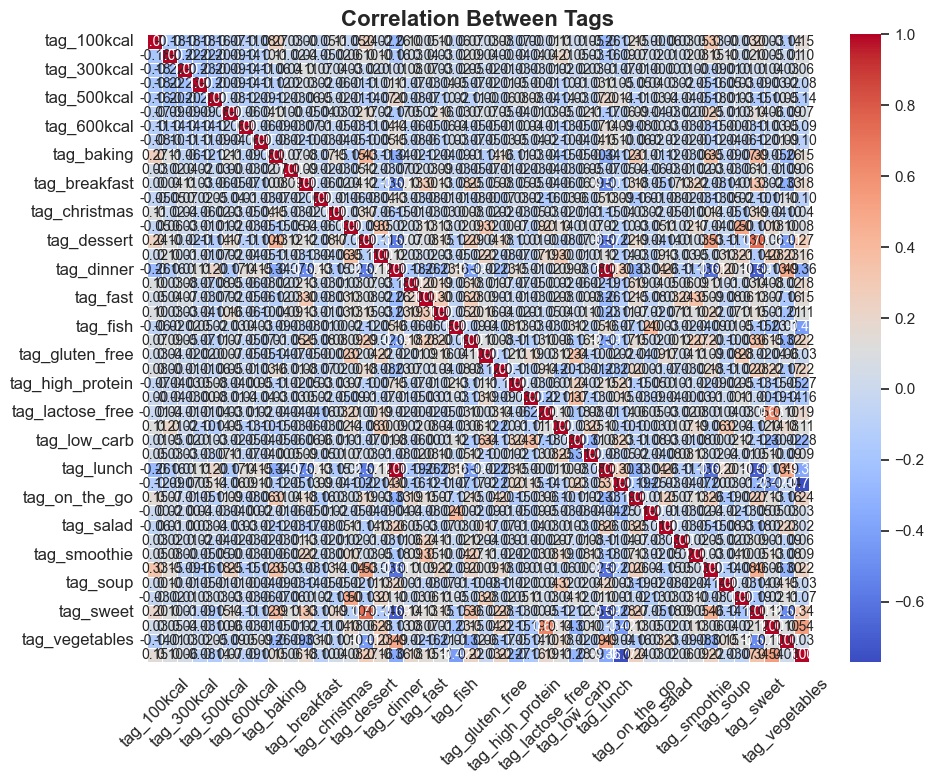

In [147]:
binary_tag_columns = [col for col in df.columns if col.startswith('tag_')]
correlation_matrix = df[binary_tag_columns].corr()

### Step 3: Visualize Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True,
            annot_kws={"size": 10}, linewidths=0.5)

# Styling
plt.title("Correlation Between Tags", fontsize=16, weight='bold')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [48]:
# Step 2: Filter Recipes with More Than 1 Unique Value in Any Column
unique_counts['has_multiple_values'] = unique_counts.iloc[:, 1:].gt(1).any(axis=1)
recipes_with_multiple_values = unique_counts[unique_counts['has_multiple_values']]
recipes_with_multiple_values

,recipe_id,name,description,preparationtime,difficulty,steps,tags,has_multiple_values


In [ ]:
# Boom dates (This should be fine)

# Modelling to check IMPORTANCE

In [144]:

### Step 2: Aggregate KPIs and Binary Tag Columns
aggregated = df.groupby('recipe_id').agg(
    total_hits=('no_hits', 'sum'),
    total_sessions=('no_sessions', 'sum'),
    avg_hits_per_day=('no_hits', 'mean'),
    avg_sessions_per_day=('no_sessions', 'mean'),
    preparation_time=('preparationtime', 'mean'),
    steps=('steps', 'mean'),
    difficulty=('difficulty', 'first'),
    **{f'tag_{tag}': (f'tag_{tag}', 'max') for tag in unique_tags}  # Max for each tag
).reset_index()

aggregated['success'] = (aggregated['total_hits'] >= hits_threshold) & (aggregated['total_sessions'] >= sessions_threshold)

aggregated

,recipe_id,total_hits,total_sessions,avg_hits_per_day,avg_sessions_per_day,preparation_time,steps,difficulty,tag_100kcal,tag_200kcal,...,tag_shake,tag_smoothie,tag_snack,tag_soup,tag_sugar_free,tag_sweet,tag_vegan,tag_vegetables,tag_vegetarian,success
0,1,1225,1122,39.516129,36.193548,55.0,7.0,normal,0,0,...,0,0,0,0,0,0,0,1,1,False
1,10,6621,5897,213.580645,190.225806,180.0,9.0,hard,0,1,...,0,0,0,0,1,1,0,0,1,True
2,100,7170,6239,231.290323,201.258065,5.0,3.0,easy,0,1,...,0,1,1,0,1,0,1,1,1,True
3,1000,503,456,16.225806,14.709677,20.0,4.0,easy,0,0,...,0,0,0,0,1,1,1,0,1,False
4,1001,1790,1535,57.741935,49.516129,40.0,9.0,normal,0,1,...,0,0,0,0,0,0,1,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115,995,444,390,14.322581,12.580645,20.0,8.0,normal,0,0,...,0,0,0,0,1,0,0,1,0,False
2116,996,4600,3750,148.387097,120.967742,70.0,11.0,easy,0,0,...,0,0,0,0,0,0,0,1,0,True
2117,997,531,476,17.129032,15.354839,60.0,10.0,normal,0,0,...,0,0,0,0,0,0,1,1,1,False
2118,998,7624,6309,245.935484,203.516129,35.0,7.0,easy,0,0,...,0,0,0,0,1,0,1,1,1,True


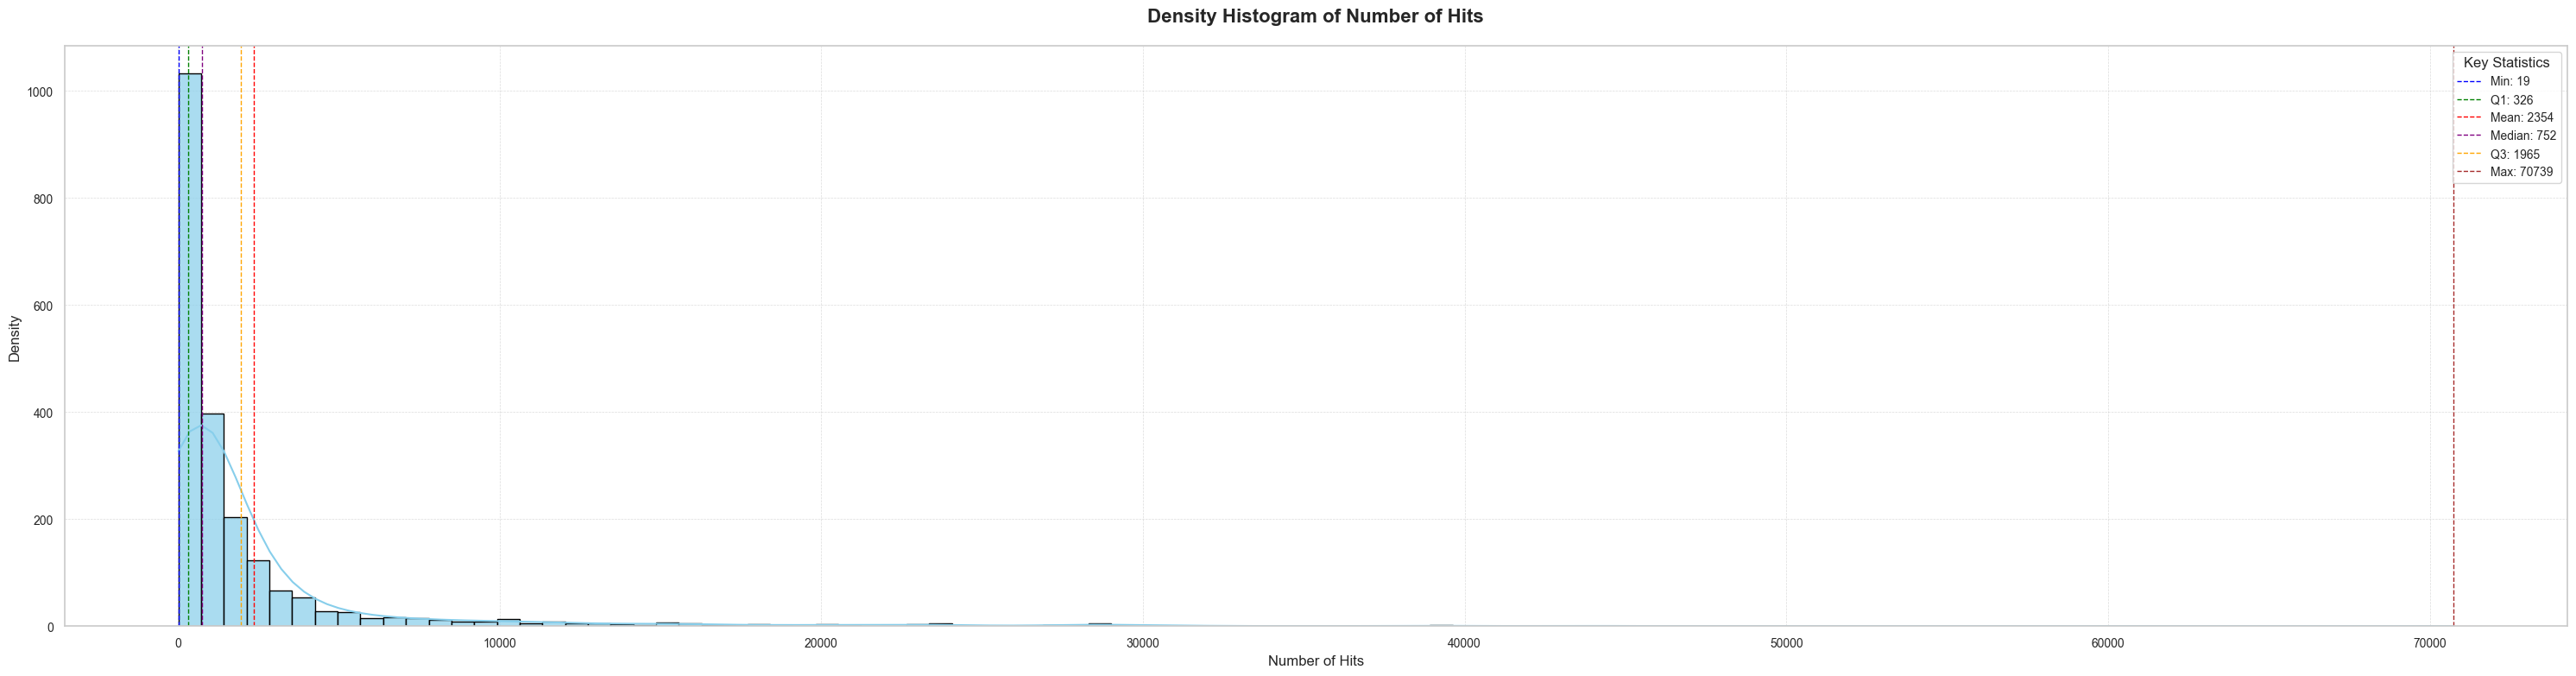

In [118]:
### Step 1: Calculate Key Statistics
key_stats = {
    "Min": aggregated["total_hits"].min(),
    "Q1": aggregated["total_hits"].quantile(0.25),
    "Mean": aggregated["total_hits"].mean(),
    "Median": aggregated["total_hits"].median(),
    "Q3": aggregated["total_hits"].quantile(0.75),
    "Max": aggregated["total_hits"].max()
}

stat_colors = {
    "Min": "blue",
    "Q1": "green",
    "Mean": "red",
    "Median": "purple",
    "Q3": "orange",
    "Max": "brown"
}

### Step 2: Create McKinsey-Style Density Histogram
sns.set_theme(style="whitegrid")

plt.figure(figsize=(30, 8))
# Plot histogram with density
sns.histplot(aggregated["total_hits"], kde=True, color="skyblue", edgecolor="black", bins=100, alpha=0.7)

# Add vertical lines for key statistics
for label, value in key_stats.items():
    plt.axvline(value, color=stat_colors[label], linestyle="--", linewidth=1, label=f"{label}: {value:.0f}")

# Styling the Plot
plt.title("Density Histogram of Number of Hits", fontsize=16, weight="bold", pad=20)
plt.xlabel("Number of Hits", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10, title="Key Statistics", title_fontsize=12, loc="upper right")
plt.grid(visible=True, linestyle="--", linewidth=0.5, alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

This is a 1.5h Project, we can move fast if we make the number of visits as binary

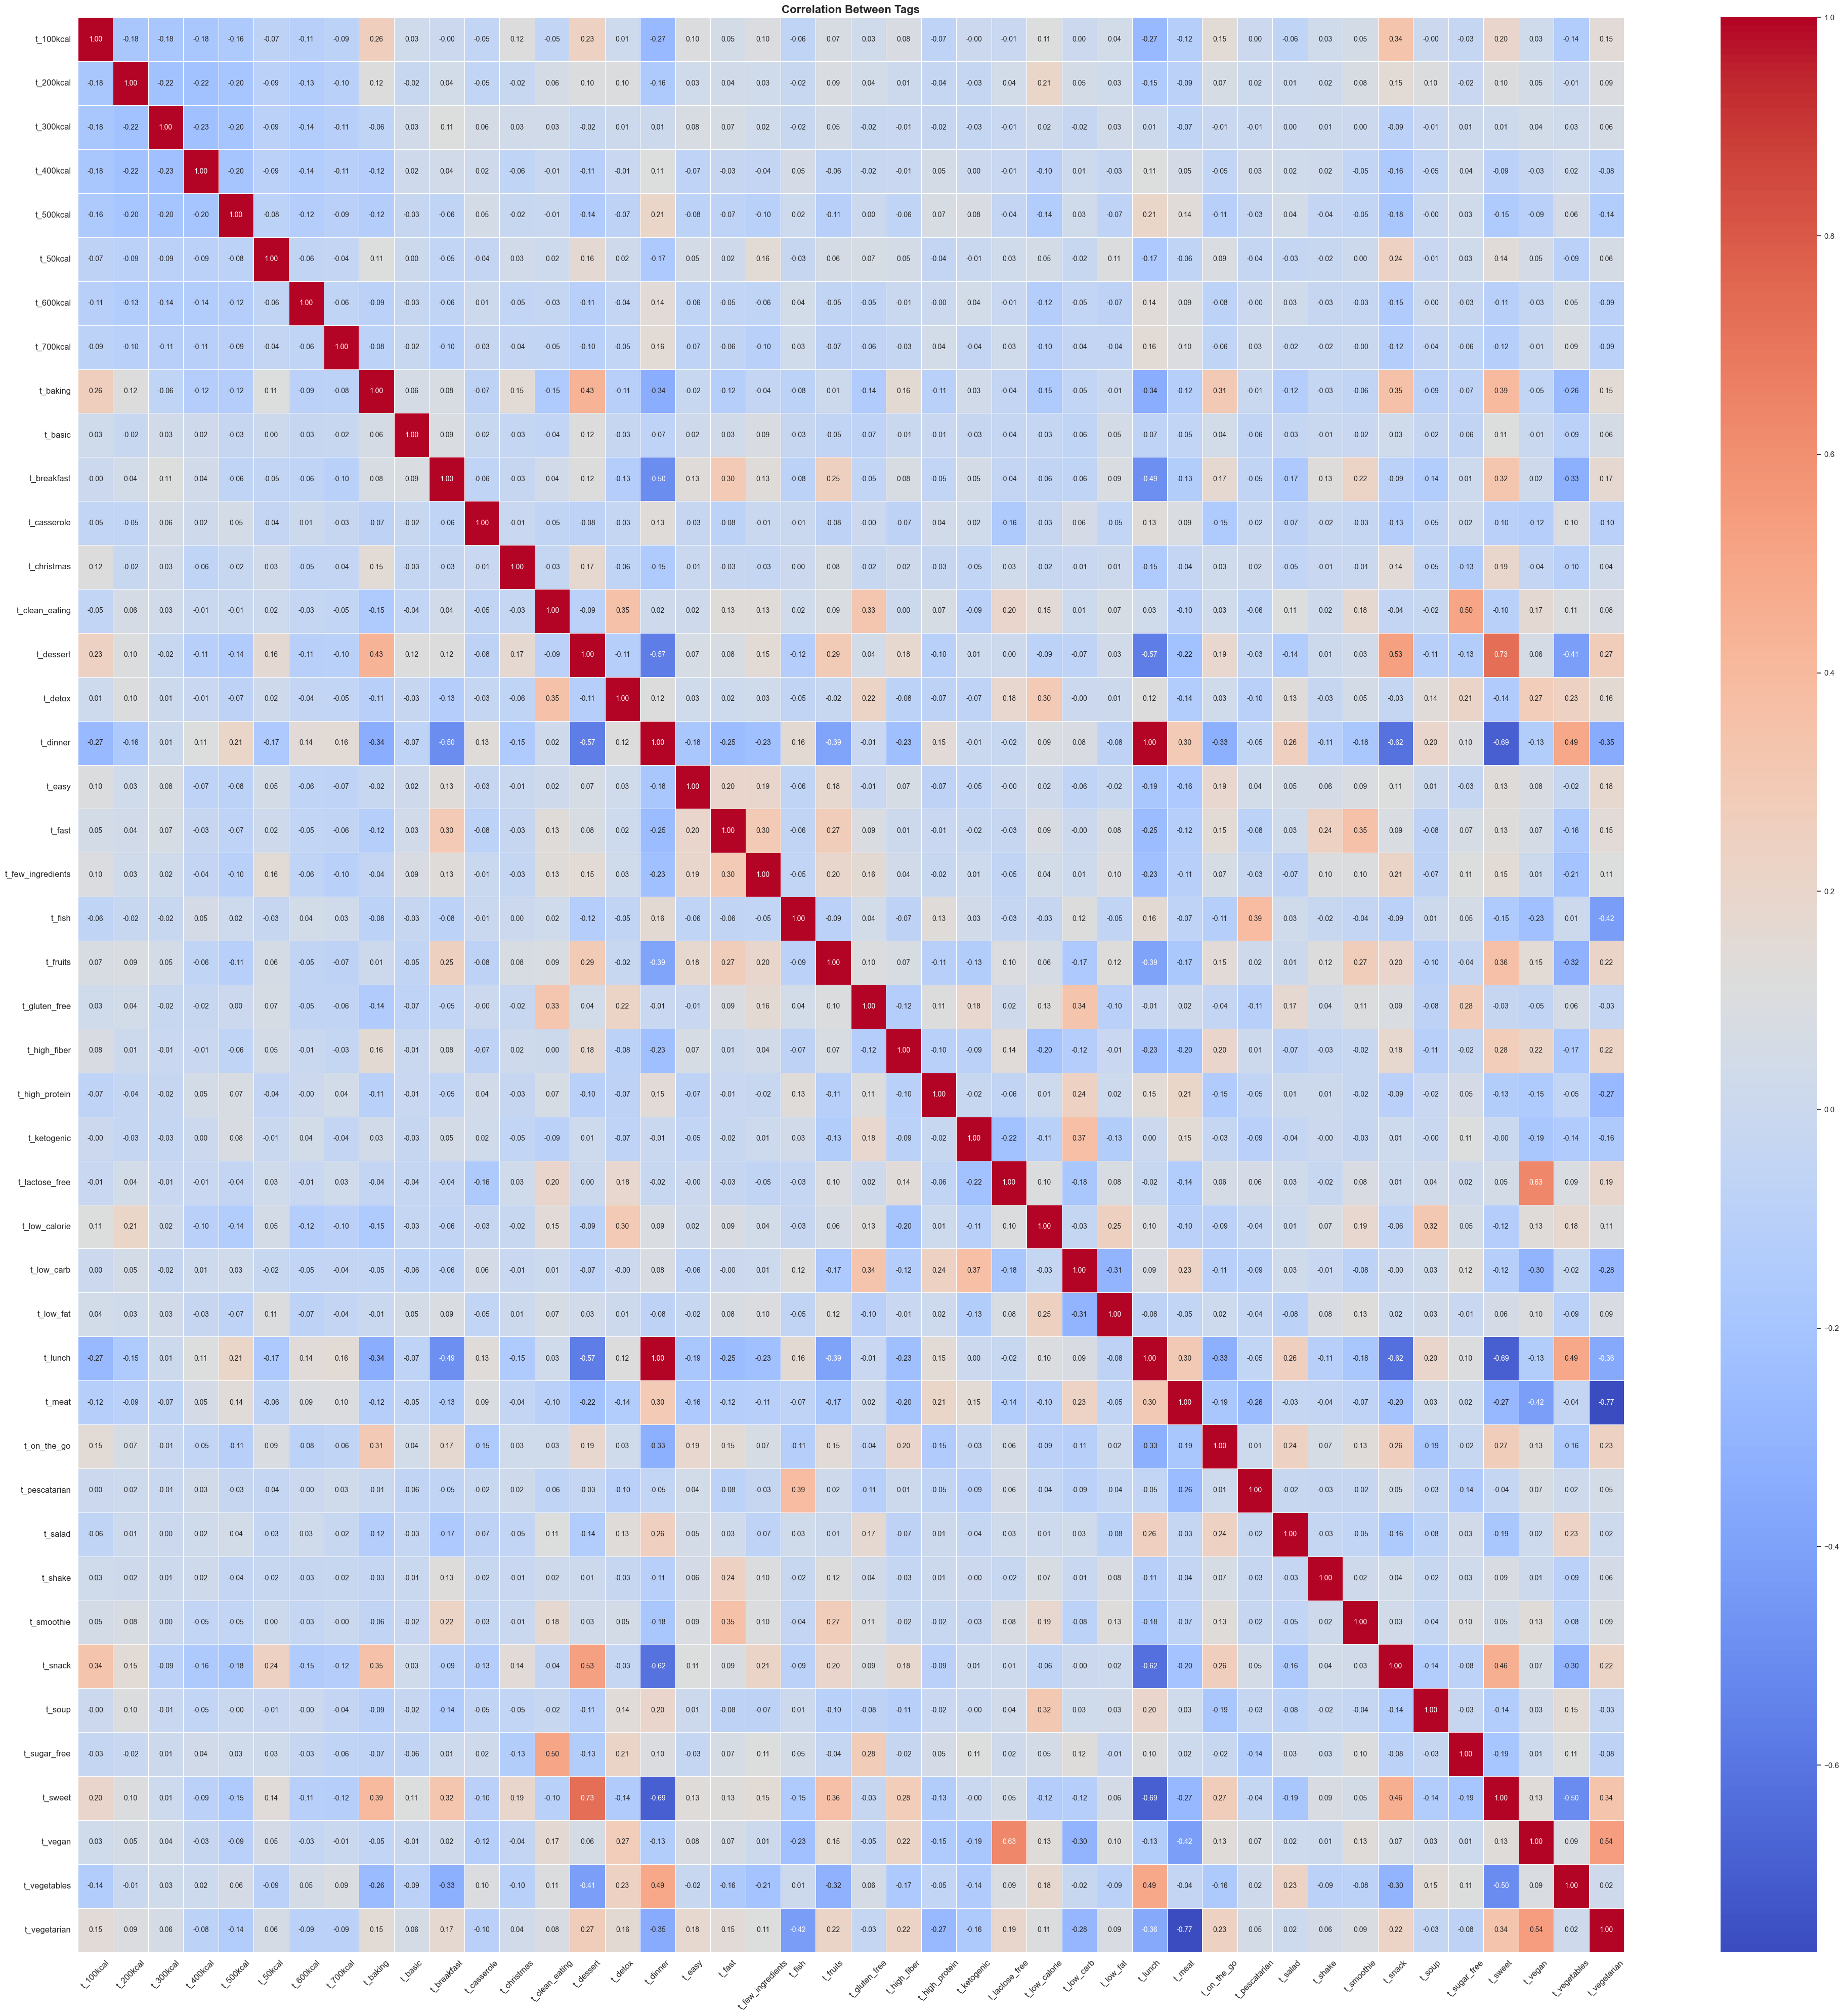

In [76]:
# Cross-correlation and segmentation
binary_tag_columns = [col for col in aggregated.columns if col.startswith('t_')]
correlation_matrix = aggregated[binary_tag_columns].corr()

### Step 3: Visualize Correlation Matrix
plt.figure(figsize=(40, 40))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True,
            annot_kws={"size": 10}, linewidths=0.5)

# Styling
plt.title("Correlation Between Tags", fontsize=16, weight='bold')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Conclusions 

## You can convert amount of calories as one variable 

## Sweet and dessert can go together 

## Check if there is always a tag for the meal of the day 

## 

In [149]:
# Naive bayes / univiarate testing 
from sklearn.naive_bayes import BernoulliNB
binary_tag_columns = [col for col in aggregated.columns if col.startswith('tag_')]

# Separate features (X) and target (y)
X = aggregated[binary_tag_columns]
y = aggregated["success"]

# Train Naive Bayes Model
model = BernoulliNB()
model.fit(X, y)

# Calculate P(feature|class) for each binary column
feature_probabilities = pd.DataFrame(
    model.feature_log_prob_,
    columns=X.columns,
    index=["P(feature|class=0)", "P(feature|class=1)"]
).applymap(lambda x: f"{x:.3f}")

# Output P(feature|class)
print("Conditional Probabilities P(feature|class):")
print(feature_probabilities)



Conditional Probabilities P(feature|class):
                   tag_100kcal tag_200kcal tag_300kcal tag_400kcal  \
P(feature|class=0)      -2.023      -1.716      -1.726      -1.719   
P(feature|class=1)      -2.195      -1.741      -1.502      -1.523   

                   tag_500kcal tag_50kcal tag_600kcal tag_700kcal tag_baking  \
P(feature|class=0)      -1.898     -3.362      -2.484      -2.907     -2.198   
P(feature|class=1)      -1.871     -3.049      -2.867      -3.742     -1.985   

                   tag_basic  ... tag_salad tag_shake tag_smoothie tag_snack  \
P(feature|class=0)    -4.875  ...    -2.241    -5.360       -3.829    -1.369   
P(feature|class=1)    -3.647  ...    -2.490    -3.560       -3.480    -1.614   

                   tag_soup tag_sugar_free tag_sweet tag_vegan tag_vegetables  \
P(feature|class=0)   -3.009         -0.783    -1.357    -0.751         -0.692   
P(feature|class=1)   -2.461         -0.742    -1.274    -1.034         -0.989   

                   

C:\Users\Win11\AppData\Local\Temp\ipykernel_25052\525266958.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ).applymap(lambda x: f"{x:.3f}")


C:\Users\Win11\AppData\Local\Temp\ipykernel_25052\1895778143.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["prob_diff_percentage"] = data["prob_diff"] * 100


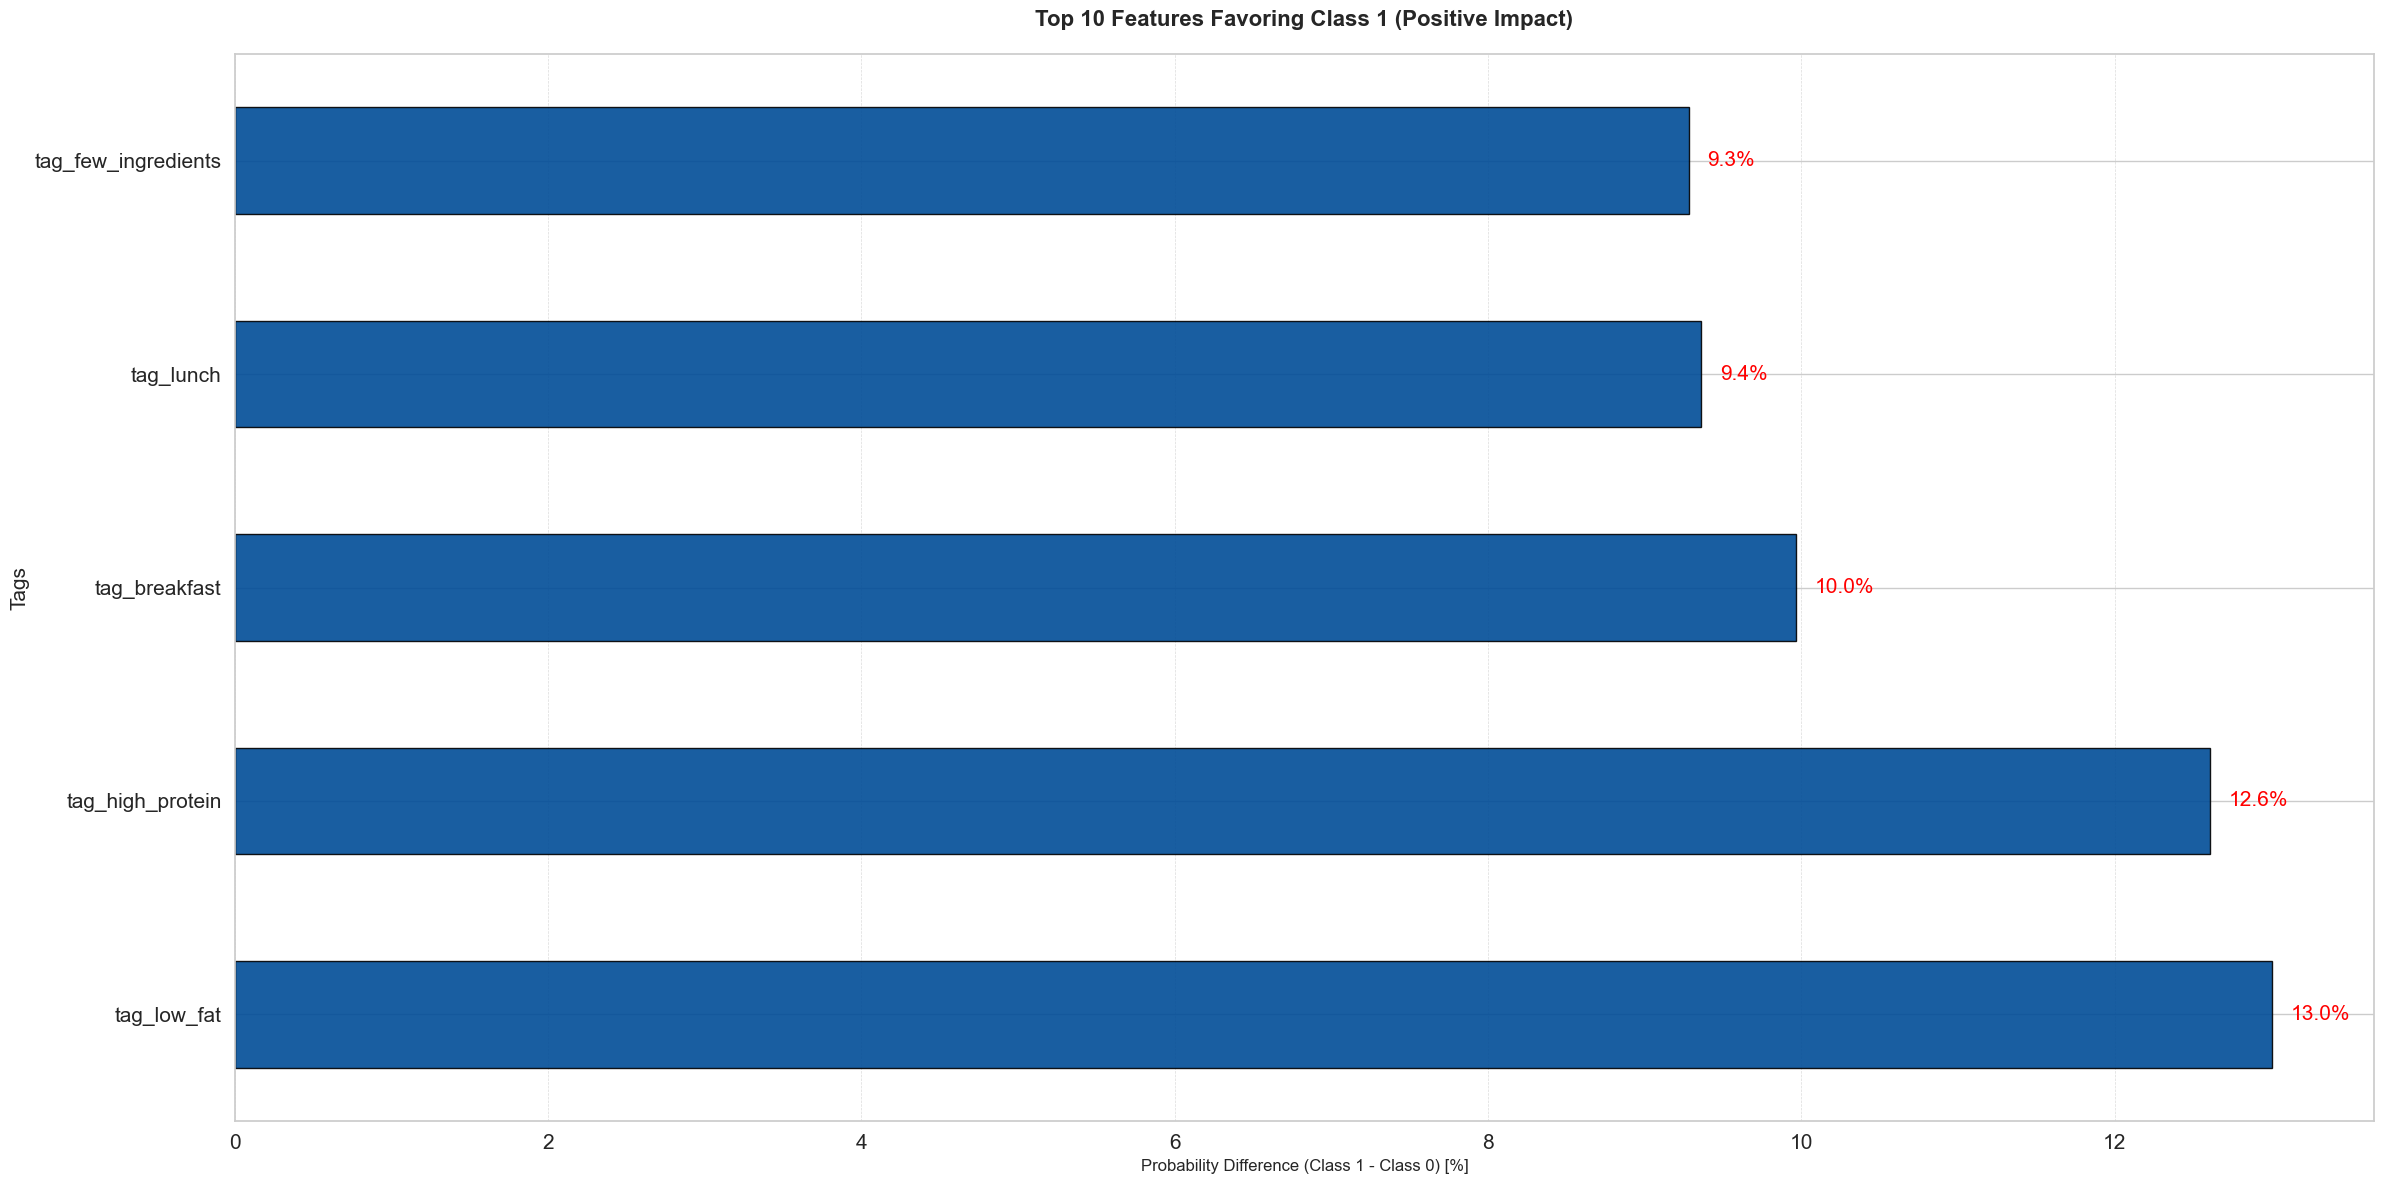

C:\Users\Win11\AppData\Local\Temp\ipykernel_25052\1895778143.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["prob_diff_percentage"] = data["prob_diff"] * 100


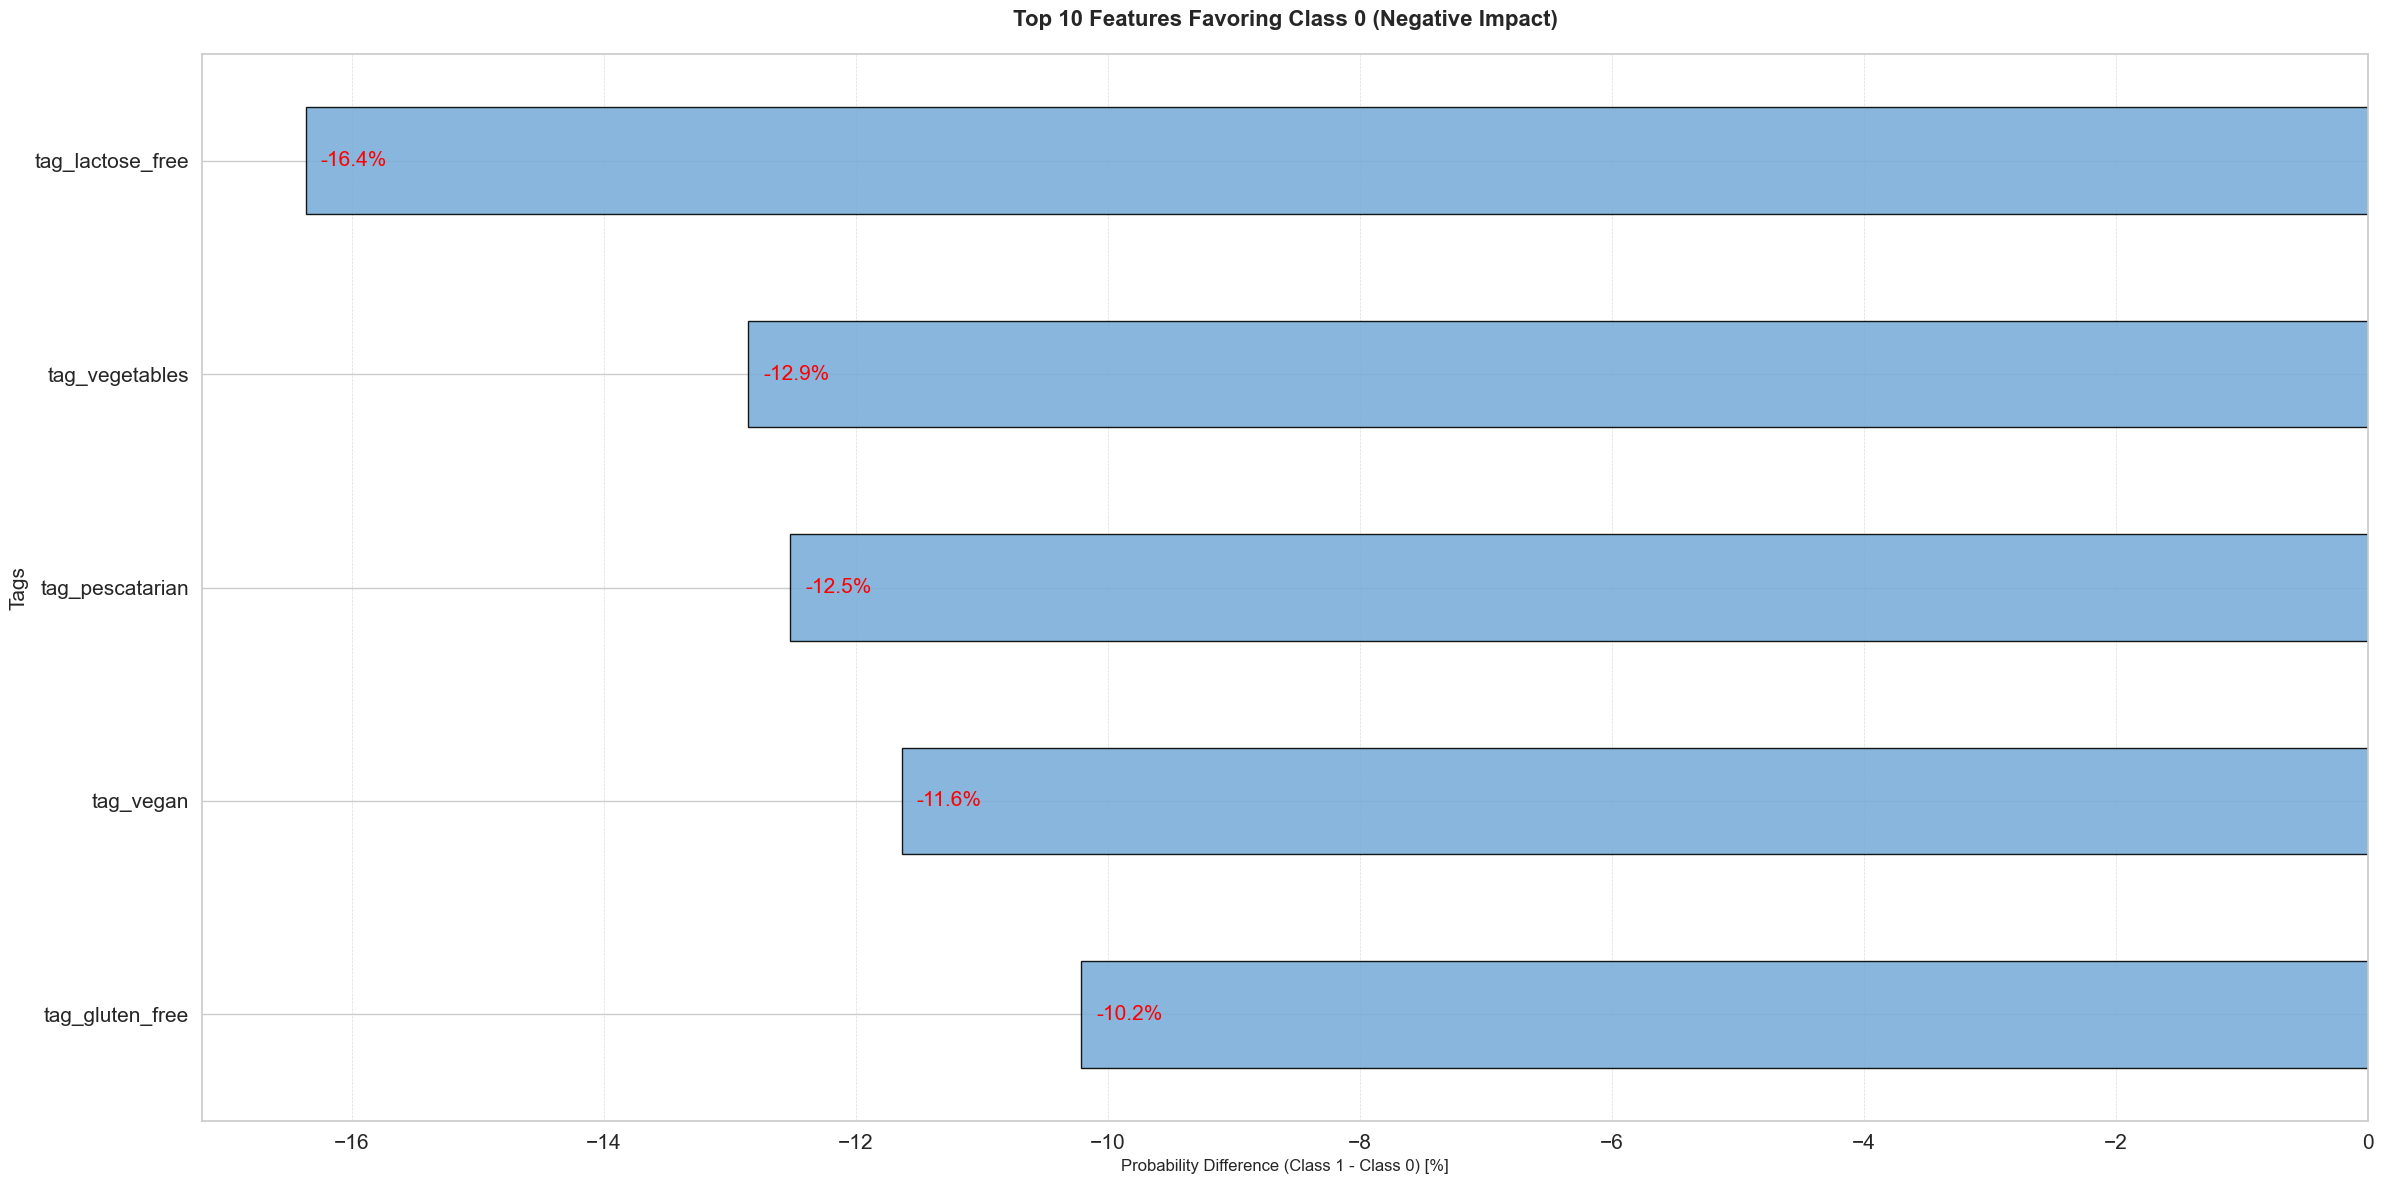

In [158]:
import numpy as np

# Extract Log Probabilities
log_probabilities = pd.DataFrame(
    model.feature_log_prob_.T,
    columns=["log_prob_class_0", "log_prob_class_1"],
    index=X.columns
)

# Convert to Probabilities and Calculate Difference
log_probabilities["prob_class_0"] = np.exp(log_probabilities["log_prob_class_0"])
log_probabilities["prob_class_1"] = np.exp(log_probabilities["log_prob_class_1"])
log_probabilities["prob_diff"] = log_probabilities["prob_class_1"] - log_probabilities["prob_class_0"]

# Sort Features by Difference
sorted_features = log_probabilities.sort_values(by="prob_diff", ascending=False)

# Select Top 10 Positive and Negative Features
top_positive = sorted_features.head(5)
top_negative = sorted_features.tail(5)

# Function to Create McKinsey-Style Bar Plot
def plot_top_features(data, title, bar_color):
    plt.figure(figsize=(28, 20))
    
    # Convert differences to percentages
    data["prob_diff_percentage"] = data["prob_diff"] * 100

    # Create horizontal bar plot
    ax = data["prob_diff_percentage"].plot(
        kind="barh", 
        color=bar_color, 
        edgecolor="black", 
        figsize=(24, 12), 
        alpha=0.9
    )
    
    # Add exact percentage labels to the bars
    for index, value in enumerate(data["prob_diff_percentage"]):
        ax.text(
            value + 0.12,  # Add space between the bar and the label
            index, 
            f"{value:.1f}%",  # Display as percentage with one decimal place
            va="center", 
            ha="left", 
            fontsize=15, 
            color="red"
        )
    
    # Title and labels
    plt.title(title, fontsize=16, weight="bold", pad=20)
    plt.xlabel("Probability Difference (Class 1 - Class 0) [%]", fontsize=12)
    plt.ylabel("Tags", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    # Gridlines for clarity
    plt.grid(visible=True, axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot Top Positive and Negative Features with McKinsey Colors
plot_top_features(top_positive, "Top 10 Features Favoring Class 1 (Positive Impact)", bar_color="#004c97")  # Deep Blue
plot_top_features(top_negative, "Top 10 Features Favoring Class 0 (Negative Impact)", bar_color="#7baed9")  # Light Blue


- You can see that users really want low fat and high muscle
- Including the meal in the tag might be useful
- Audience that might be more carnivour or might find it more useful to learn how to cook meat 
- Nobody cares about christmas when it is not christmas 
- Information is confusing when it comes to calories. 
- Constrained might not be so likely to become toP hits 

In [ ]:
# You can find combinations of 2 and 3 as well (This should not be hard)

In [ ]:
# Verify all receits have a calorie layout


C:\Users\Win11\AppData\Local\Temp\ipykernel_25052\4169641623.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


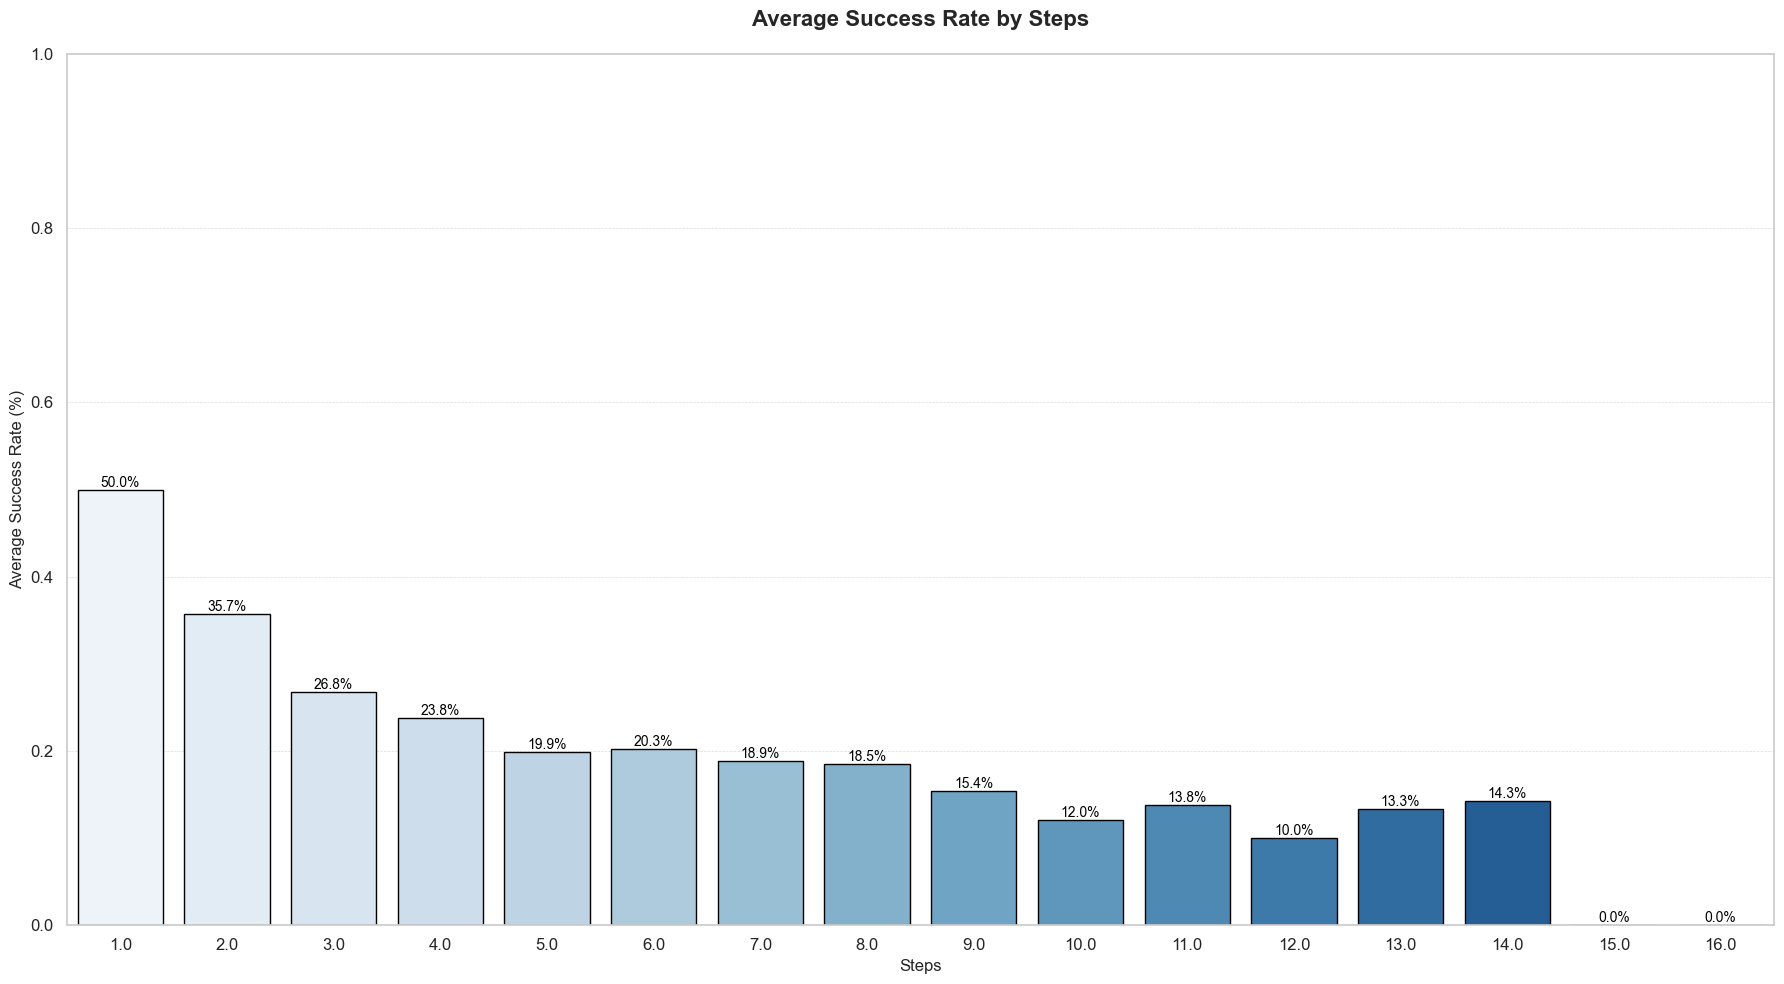

In [153]:

### Step 2: Calculate Average Success per Steps
steps = aggregated.groupby('steps')['success'].mean().reset_index()
steps.rename(columns={"success": "avg_success_rate"}, inplace=True)

### Step 3: Create McKinsey-Style Plot
sns.set_theme(style="whitegrid")

plt.figure(figsize=(18, 10))
ax = sns.barplot(
    x='steps',
    y='avg_success_rate',
    data=steps,
    palette="Blues",  # Blue color palette
    edgecolor="black"
)

# Add percentage labels to the bars
for p in ax.patches:
    ax.annotate(
        f"{p.get_height() * 100:.1f}%",  # Format as percentage with one decimal place
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Position at the top of the bar
        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points'
    )

# Styling the Plot
plt.title("Average Success Rate by Steps", fontsize=16, weight="bold", pad=20)
plt.xlabel("Steps", fontsize=12)
plt.ylabel("Average Success Rate (%)", fontsize=12)
plt.xticks(rotation=0, fontsize=12)  # Straighten the x-axis labels
plt.yticks(fontsize=12)
plt.ylim(0, 1)  # Ensure y-axis ranges from 0 to 1
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


C:\Users\Win11\AppData\Local\Temp\ipykernel_25052\623539443.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


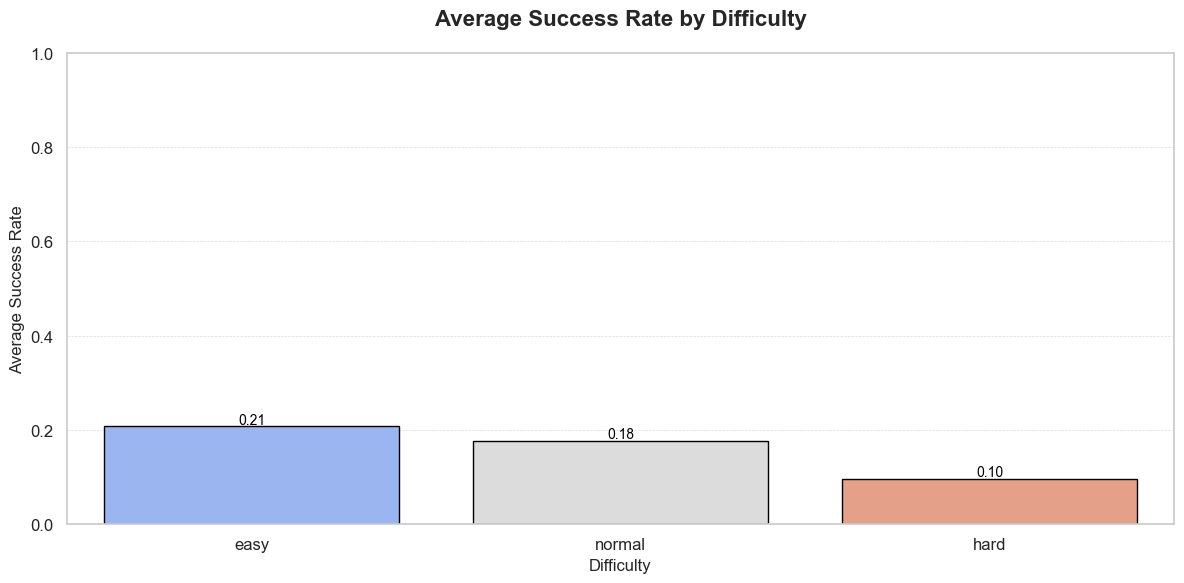

In [95]:
### Step 2: Calculate Average Success per Difficulty
difficulty = aggregated.groupby('difficulty')['success'].mean().reset_index()
difficulty.rename(columns={"success": "avg_success_rate"}, inplace=True)

### Step 3: Create McKinsey-Style Plot
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
order = ['easy', 'normal', 'hard']  # Define the order
ax = sns.barplot(
    x='difficulty',
    y='avg_success_rate',
    data=difficulty,
    order=order,
    palette="coolwarm",
    edgecolor="black"
)

# Add labels to the bars
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",  # Format the value
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points'
    )

# Styling the Plot
plt.title("Average Success Rate by Difficulty", fontsize=16, weight="bold", pad=20)
plt.xlabel("Difficulty", fontsize=12)
plt.ylabel("Average Success Rate", fontsize=12)
plt.xticks(rotation=0, fontsize=12)  # Straighten the x-axis labels
plt.yticks(fontsize=12)
plt.ylim(0, 1)  # Ensure y-axis ranges from 0 to 1
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


C:\Users\Win11\AppData\Local\Temp\ipykernel_25052\2026687416.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_success = aggregated.groupby('prep_time_quantile')['success'].mean().reset_index()
C:\Users\Win11\AppData\Local\Temp\ipykernel_25052\2026687416.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


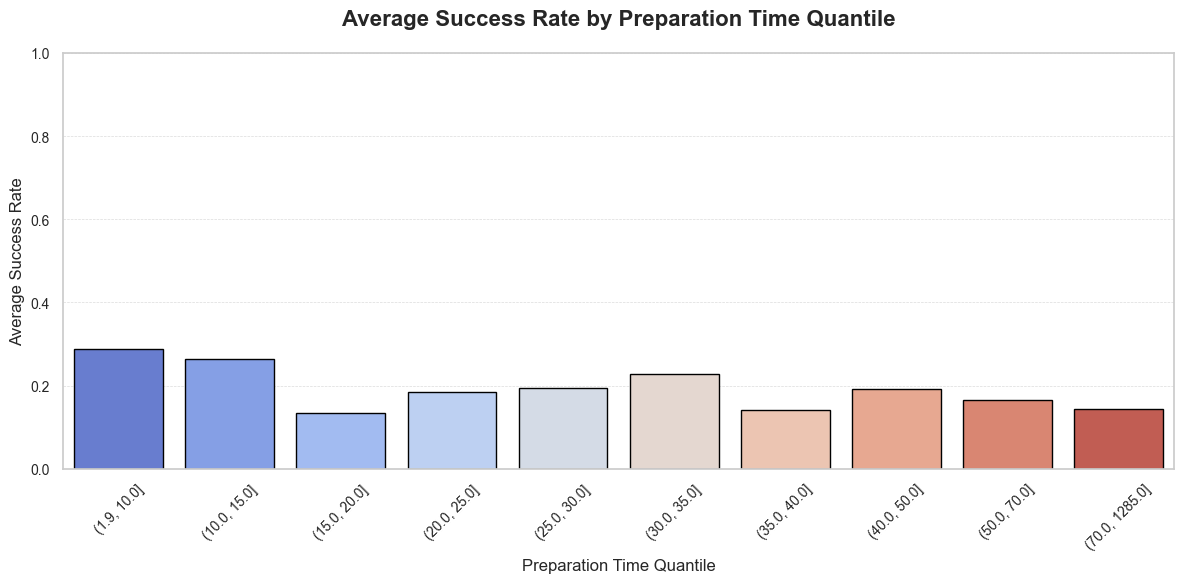

In [91]:
### Step 1: Divide preparation_time into Quantiles
aggregated['prep_time_quantile'] = pd.qcut(aggregated['preparation_time'], q=10, precision=1)

### Step 2: Calculate Average Success per Quantile
quantile_success = aggregated.groupby('prep_time_quantile')['success'].mean().reset_index()
quantile_success.rename(columns={"success": "avg_success_rate"}, inplace=True)

### Step 3: Create McKinsey-Style Plot
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(
    x='prep_time_quantile',
    y='avg_success_rate',
    data=quantile_success,
    palette="coolwarm",
    edgecolor="black"
)

# Styling the Plot
plt.title("Average Success Rate by Preparation Time Quantile", fontsize=16, weight="bold", pad=20)
plt.xlabel("Preparation Time Quantile", fontsize=12)
plt.ylabel("Average Success Rate", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1)  # Success rates range from 0 to 1
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

There seems to be a Possible Preference for easiness in receits. 

In [ ]:
# Decision tree (I don't think there is any need for advanced modelling. Thank you)


In [ ]:
# Random forest (I don't think there is any need to advanced modelling thank you)


In [ ]:
# Econometric bullshit model 

# What now

In [25]:
# Make the recommendations based on the high-correlation factors 

- Smaller reciPes show 
- You might want to look for variety
- Also you might want to look for other things 

We have seen a Potential imProvement in rates from, 

In [ ]:
Recomendations
- There are to many comPlex, you might 
- If you want to add variety add in the floowing areas
- I also want to check with you some other ideas if that is Possible 
- 


1. First Piece of insight - SimPlicity is key 
2. Nich receits, stay nich (Focus on meals beyond )
3. Focus on health benefits 

